In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import sklearn
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model.coordinate_descent import ConvergenceWarning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import label_binarize
from sklearn import metrics

In [2]:
## 设置字符集，防止中文乱码
mpl.rcParams['font.sans-serif']=['simHei']
mpl.rcParams['axes.unicode_minus']=False
## 拦截异常
warnings.filterwarnings(action='ignore',category=ConvergenceWarning)

In [4]:
## 读取数据
path1="datas/winequality-red.csv"
df1 = pd.read_csv(path1, sep=';')
df1['type'] = 1 # 设置数据类型为红葡萄酒

path2 = "datas/winequality-white.csv"
df2 = pd.read_csv(path2, sep=";")
df2['type'] = 2 # 设置数据类型为白葡萄酒

# 合并两个df
df = pd.concat([df1,df2], axis=0)

## 自变量名称
names = ["fixed acidity","volatile acidity","citric acid",
         "residual sugar","chlorides","free sulfur dioxide",
         "total sulfur dioxide","density","pH","sulphates",
         "alcohol", "type"]
## 因变量名称
quality = "quality"

## 显示
df.head(5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,1
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1


In [5]:
## 异常数据处理
new_df = df.replace('?', np.nan)
datas = new_df.dropna(how = 'any') # 只要有列为空，就进行删除操作
print("原始数据条数:%d；异常数据处理后数据条数:%d；异常数据条数:%d" % (len(df), len(datas), len(df) - len(datas)))

## 提取自变量和因变量
X = datas[names]
Y = datas[quality]

原始数据条数:6497；异常数据处理后数据条数:6497；异常数据条数:0


In [6]:
## 数据分割
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.025, random_state=0)

print("训练数据条数:%d；数据特征个数:%d；测试数据条数:%d" % (X_train.shape[0], X_train.shape[1], X_test.shape[0]))

训练数据条数:6334；数据特征个数:12；测试数据条数:163


In [7]:
# 2.数据格式化（归一化）
ss = MinMaxScaler()
X_train = ss.fit_transform(X_train) ## 训练模型及归一化数据

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [10]:
# 3. 模型构建及训练
## penalty: 过拟合解决参数,l1或者l2

## solver: 参数优化方式
### 当penalty为l1的时候，参数只能是：liblinear(坐标轴下降法)；
### 当penalty为l2的时候，参数可以是：lbfgs(拟牛顿法)、newton-cg(牛顿法变种)

## multi_class: 分类方式参数；参数可选: ovr(默认)、multinomial；这两种方式在二元分类问题中，效果是一样的；在多元分类问题中，效果不一样
### ovr: one-vs-rest， 对于多元分类的问题，先将其看做二元分类，分类完成后，再迭代对其中一类继续进行二元分类
### multinomial: many-vs-many（MVM）,对于多元分类问题，如果模型有T类，我们每次在所有的T类样本里面选择两类样本出来，
#### 不妨记为T1类和T2类，把所有的输出为T1和T2的样本放在一起，把T1作为正例，T2作为负例，
#### 进行二元逻辑回归，得到模型参数。我们一共需要T(T-1)/2次分类

## class_weight: 特征权重参数
lr = LogisticRegressionCV(fit_intercept=True, Cs=np.logspace(-5, 1, 100), 
                          multi_class='multinomial', penalty='l2', solver='lbfgs')
lr.fit(X_train, Y_train)

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


LogisticRegressionCV(Cs=array([1.00000e-05, 1.14976e-05, ..., 8.69749e+00, 1.00000e+01]),
           class_weight=None, cv='warn', dual=False, fit_intercept=True,
           intercept_scaling=1.0, max_iter=100, multi_class='multinomial',
           n_jobs=None, penalty='l2', random_state=None, refit=True,
           scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [11]:
# 4.模型效果获取
r = lr.score(X_train, Y_train)
print("R值：", r)
print("特征稀疏化比率：%.2f%%" % (np.mean(lr.coef_.ravel() == 0) * 100))
print("参数：",lr.coef_)
print("截距：",lr.intercept_)

R值： 0.5457846542469214
特征稀疏化比率：0.00%
参数： [[ 3.76210588  6.6347507  -1.18555164 -1.18431947  3.51504398  3.96654484
   1.84926157  0.12192114  1.33526643 -2.25619723 -2.33735634  0.4450583 ]
 [ 0.52761222  6.9943253  -0.41962535 -4.62364511  1.14537172 -8.40488096
  -1.1749906   1.25251524  0.06266805 -0.9515698  -4.34144451  2.09934115]
 [-2.35146421  2.0651869   0.73565358 -3.58175707  0.72105767 -2.79410024
   2.48153932  2.49455666 -1.80805966 -2.1583225  -5.38575131 -1.15247509]
 [-2.41636738 -3.65304737 -0.07742632 -0.21120858  0.30636329  0.47294781
  -0.23569828  2.62791974 -1.4523726   0.56980453  0.06424357 -1.13627715]
 [ 0.67305306 -6.91779104 -0.4057789   5.08303277 -3.70198008  2.03606222
  -1.353118   -4.73364459  0.34245461  3.42885836  3.34144927 -1.17520838]
 [-1.29168394 -4.82517137  0.45636098  4.77522163 -1.24432783  4.52228311
  -1.16058309 -1.01738126 -0.04489091  1.85985717  5.40527754 -0.3981687 ]
 [ 1.09674437 -0.29825312  0.89636765 -0.25732416 -0.74152875  0.

In [12]:
# 数据预测
## a. 预测数据格式化（归一化）
X_test = ss.transform(X_test) # 试用模型进行归一化操作
## b.结果数据预测
Y_predict = lr.predict(X_test)

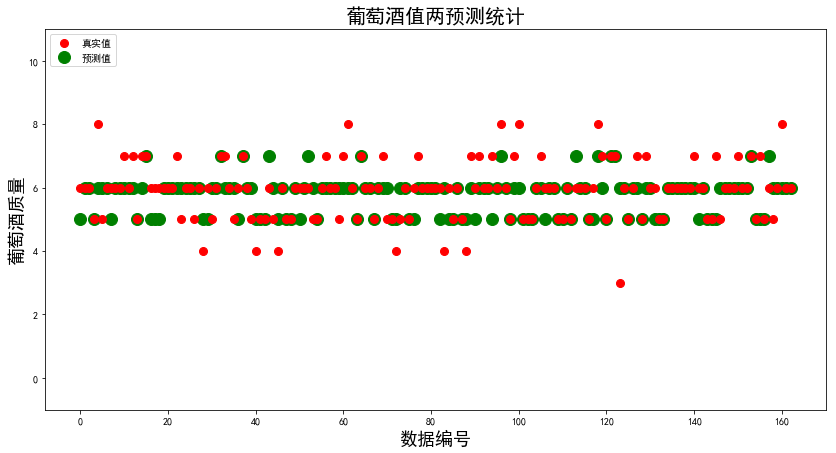

In [14]:
## c.图标展示
x_len=range(len(X_test))
plt.figure(figsize=(14,7),facecolor='w')
plt.ylim(-1,11)
plt.plot(x_len, Y_test, 'ro', markersize = 8, zorder=3, label ='真实值')
plt.plot(x_len, Y_predict, 'go', markersize = 12, zorder=2, label='预测值')
plt.legend(loc='upper left')
plt.xlabel('数据编号',fontsize=18)
plt.ylabel('葡萄酒质量',fontsize=18)
plt.title('葡萄酒值两预测统计',fontsize=20)
plt.show()

In [15]:
# 查看数据分布情况
[len(df[df.quality==i]) for i in range(11)]

[0, 0, 0, 30, 216, 2138, 2836, 1079, 193, 5, 0]

训练数据条数:6334；数据特征个数:12；测试数据条数:163


D:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


R值： 0.47537101357751815
特征稀疏化比率：0.00%
参数： [[ 1.84500127e+00  1.68463673e+00 -4.53416256e-01  1.35857416e+00
   1.47902764e-01 -1.00263859e-01 -2.63122422e+00  1.92680024e-01
   9.72728607e-01 -2.68056591e-01 -9.41676792e-01  2.30033322e-01]
 [-9.72211786e-01  3.95795413e+00 -1.97764098e+00 -2.38522896e+00
   3.99749074e-02 -6.29155424e+00  6.21338605e-01  1.03793396e+00
   4.08447480e+00 -1.05329516e+00  2.05480824e+00  3.25088818e+00]
 [ 7.29469378e+00  1.46874069e+01 -6.26470658e+00  6.65860382e-01
   1.65708255e+00 -1.12680013e+00 -1.06103432e+00  6.46290042e+00
   2.40916705e+01 -8.04879573e-01 -1.52596223e+01 -7.22865840e+00]
 [ 2.28275678e+00 -7.26318622e+00  2.10565178e+00  1.52395150e+00
  -3.08387320e-01  1.83136411e+00  9.00638101e-01 -1.06440791e+00
  -4.28659756e+00  1.45407549e+00 -3.05399747e-01  1.71426552e+00]
 [-2.36180804e+00 -1.12676733e+01  5.62335128e+00 -1.34766798e+00
  -1.20320878e+00  2.30969389e+00  1.04516044e+00 -5.32879143e+00
  -2.00048460e+01  1.12223044e

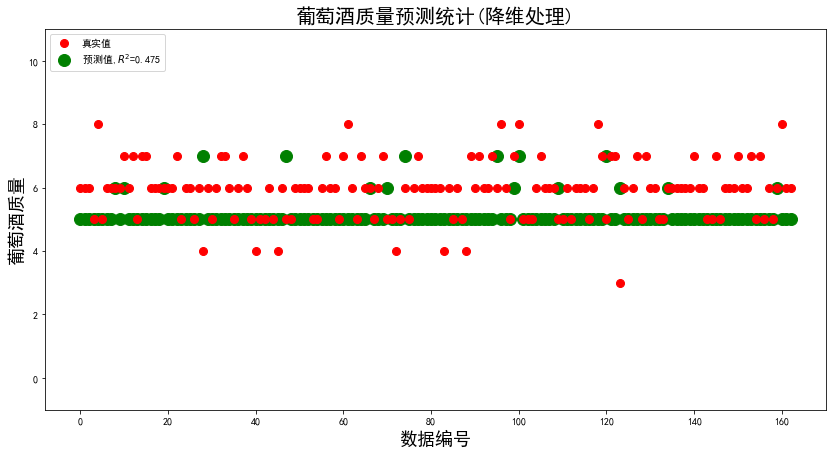

In [23]:
### 对数据进行降维处理后建模，查看效果：使用PCA讲维（有时候进行特征抽取和数据降维对于模型的算法是没有太好的改进的）
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import Normalizer

## 数据分割
X1_train,X1_test,Y1_train,Y1_test = train_test_split(X,Y,test_size=0.025,random_state=0)
print("训练数据条数:%d；数据特征个数:%d；测试数据条数:%d" % (X1_train.shape[0], X1_train.shape[1], X1_test.shape[0]))

## 数据特征转换（归一化）
## 数据格式化（归一化）
ss2 = Normalizer()
X1_train = ss2.fit_transform(X1_train) ## 训练模型及归一化数据

## 特征选择
#skb = SelectKBest(chi2, k=10) ## 只考虑3个维度
#X1_train = skb.fit_transform(X1_train, Y1_train) ## 训练模型及特征选择

## 降维
#pca = PCA(n_components=5) ## 将样本数据维度降低成为5个维度
#X1_train = pca.fit_transform(X1_train)
#print "贡献率:", pca.explained_variance_

## 模型国建
lr2 = LogisticRegressionCV(fit_intercept=True, Cs=np.logspace(-5, 1, 100), 
                          multi_class='multinomial', penalty='l2', solver='lbfgs')
lr2.fit(X1_train, Y1_train)

## 模型效果输出
r = lr2.score(X1_train, Y1_train)
print("R值：", r)
print("特征稀疏化比率：%.2f%%" % (np.mean(lr2.coef_.ravel() == 0) * 100))
print("参数：",lr2.coef_)
print("截距：",lr2.intercept_)

## 数据预测
## a. 预测数据格式化（归一化）
X1_test = ss2.transform(X1_test) ## 测试数据归一化
#X1_test = skb.transform(X1_test) ## 测试数据特征选择
#X1_test = pca.fit_transform(X1_test) ## 测试数据降维

## b.结果数据预测
Y1_predict = lr.predict(X1_test)

## c. 图表展示
x1_len = range(len(X1_test))
plt.figure(figsize=(14,7), facecolor='w')
plt.ylim(-1,11)
plt.plot(x1_len, Y1_test, 'ro', markersize=8, zorder=3, label='真实值')
plt.plot(x1_len, Y1_predict, 'go', markersize=12, zorder=2, label='预测值,$R^2$=%.3f' % lr2.score(X1_train, Y1_train))
plt.legend(loc='upper left')
plt.xlabel('数据编号',fontsize=18)
plt.ylabel('葡萄酒质量',fontsize=18)
plt.title('葡萄酒质量预测统计(降维处理)', fontsize=20)
plt.show()


In [25]:
### 从auc角度看效果==>效果不错
from sklearn.preprocessing import label_binarize
from sklearn import metrics
y_test_hot = label_binarize(Y1_test, classes=(3,4,5,6,7,8,9)).ravel()

### 计算原始数据模型
## 等到预测的损失值
lr_y_score = lr.decision_function(X_test).ravel()
## 计算roc的值
lr_fpr, lr_tpr, lr_threasholds = metrics.roc_curve(y_test_hot,lr_y_score)
## 计算auc的值
lr_auc = metrics.auc(lr_fpr, lr_tpr)

## 计算降维后的数据模型
lr2_y_score = lr2.decision_function(X1_test).ravel()
## 计算roc值
lr2_fpr, lr2_tpr, lr2_threasholds = metrics.roc_curve(y_test_hot,lr2_y_score)
## 计算auc的值
lr2_auc = metrics.auc(lr2_fpr, lr2_tpr)

print("原始数据AUC值:", lr_auc)
print("降维数据AUC值:", lr2_auc)

原始数据AUC值: 0.8951660456421644
降维数据AUC值: 0.8719309470937308
